# TARDIGRADE Analysis

## Setup

In [1]:
import getpass
import sys
import os
if getpass.getuser() == 'mshaaban':
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai')
    jtplot.style(ticks=True, grid=False, figsize=(8, 4.5))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy import constants as const
import pandas as pd
from functools import reduce

In [2]:
base_path = "/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/"

### Notes
Here we present a tool to use to quickly look up notes on what was going on in the experiment as a function of time.

In [3]:
notes = pd.read_csv(base_path+"notes.csv")

def get_note(time,n=3):
    """A function that given a unix time stamp will return the n notes nearest to it in time"""
    args = (notes['Unix Timestamp'] - time).abs().argsort()[:n]
    return notes.iloc[args]

#### Sample Usage
- Begin by plotting beam power as a function of time. We idnetify interesting feature e.g. prolonged low power area around 1.65505e9.
- use `get_note(time,number of notes to show)` to get some notes nearest to the time of interest
- use `get_note()['Notes'][n]` to get more information on the nth note where n is the index in the table NOT the ordered index for the given size

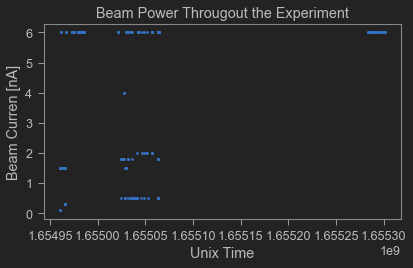

In [4]:
plt.plot(notes["Unix Timestamp"], notes["Beam Current [nA]"],'.')
plt.title("Beam Power Througout the Experiment")
plt.ylabel("Beam Curren [nA]")
plt.xlabel("Unix Time");

In [5]:
get_note(1.65505e9,5)

,Device,Short Name,Type of Test,Date,Time [PST],Unix Timestamp,Notes,Beam Current [nA],Scale Factor
142,Power Switching Relay Board - custom,psrb,Slow aging to 1650 rad,"June 12, 2022",16:23,1655050980,locking up and requesting 2nA => 500 count/s,2.0,1
141,USB to serial converter - FTDI chip,usb2serial,Slow aging to 1650 rad,"June 12, 2022",15:46,1655048760,Go up to 6 nA => 1500 count/s\r\nCompletely f...,6.0,1
143,Power Switching Relay Board - custom,psrb,Slow aging to 1650 rad,"June 12, 2022",16:30,1655051400,Shutter open beam started \r\nBoring so far 2 ...,2.0,1
140,USB to serial converter - FTDI chip,usb2serial,Slow aging to 1650 rad,"June 12, 2022",15:42,1655048520,Go up to 2 nA => 500 count /s\r\nNo errors up ...,2.0,1
144,Power Switching Relay Board - custom,psrb,Slow aging to 1650 rad,"June 12, 2022",16:33,1655051580,request 6nA => 1400 count/s\r\nStill boring,6.0,1


In [6]:
get_note(1.65505e9,5)['Notes'][143]

'Shutter open beam started \r\nBoring so far 2 minutes into it'

## Data

Due to the fact that each device had its own flavour of data for the most part each device will have to be handled indvisually with regards to data upload. In this section we hadle each case seprately. Due to RAM requirments we recommend you only load in the data that you need for your analysis.

In [187]:
def smart_hist(img, title="", bins=10000, sigma=3, label="", report=True,norm=False):
    """Simple tool to plot histogram of a 2D array image

    Args:
        img (1-2D array):
            The image array
        title (str, optional):
            Figure title. Defaults to "".
        bins (int, optional):
            Number of bins in histogram. Defaults to 10000.
        sigma (int, optional):
            Sigma clipping of the x axis. Defaults to 1.
        nfig (bool, optional):
            If True create a new figure, if False overlay on previous figure.
            Defaults to True.
        label (str, optional):
            Label of the plot if overlaying multiple figures. Defaults to "".
        report (bool, optional):
            If True report the image mean, median and std. Defaults to True.
    """
    img = np.nan_to_num(img,nan=np.mean(img))
    m = np.mean(img)
    s = np.std(img)
    hist, edge = np.histogram(img, bins=bins)
    if norm:
        hist, edge = np.histogram(img, bins=bins,density=True)
    plt.plot(edge[1:], hist, label=label)
    plt.xlim([m - (sigma * s), m + (sigma * s)])
    plt.title(title)
    plt.legend()
    temp = sorted(hist, key=lambda x: abs(x - np.max(hist) / 2))
    print("Peak =", np.max(hist),
          "FWHM = ", np.abs(
              edge[np.where(hist == temp[0])] - edge
              [np.where(hist == temp[1])])[0],)
    if report:
        print("mean:",m,"median:", np.median(img), "std:",s)

### Arduino

In [56]:
def load_ard_data(path,df=None):
    """Function to load arduino data spit out by the reader script and turn it into a usable pandas data frame"""
    if df is None:
        # create temporary data frame
        df = pd.read_csv(path)
        df.read_bytes = df.read_bytes.str.split(" ")
    
    # process data frame into usable format by breaking things 
    #like pwm_100: 140 into label and value
    vals = []
    label = []
    for mem in df.read_bytes:
        if len(mem) > 1:
            label.append(mem[0])
            vals.append(mem[1].split("\r")[0])

    # Create dictionary that maps the unique labels to all their values
    vals = np.array(vals).astype(float)
    label = np.array(label)
    dat = {}
    # get the time by subsampling all recorded times by the number of labels
    dat['time'] = np.array(df.time)[0:-1:len(set(label))]
    
    for l in set(label):
        dat[l] = vals[label==l]
    
    # Convert that dictionary into a pandas data frame for ease of use
    return pd.DataFrame.from_dict(dict([ (k,pd.Series(v)) for k,v in dat.items() ]))#.fillna(-1.0)

#### Example

In [57]:
path = base_path+"arduino"
ard_slow = load_ard_data(path+"/data/slow_dose/ard1655071123.6531866.csv")
ard_fast = load_ard_data(path+"/data/fast_dose/ard1655311267.1804419.csv")
ard_pre = load_ard_data(path+"/data/pre_beam/ard1654906400.557813.csv")

Peak = 0.6629125408191016 FWHM =  6.900000000000034
mean: 361.19794642375894 median: 359.0 std: 3.1187071375251336
Peak = 0.6602718596356055 FWHM =  6.900000000000034
mean: 361.2018626653854 median: 359.0 std: 3.1230695507993813
Peak = 0.6611178921671919 FWHM =  6.900000000000034
mean: 361.2014359470797 median: 359.0 std: 3.1237261287455063


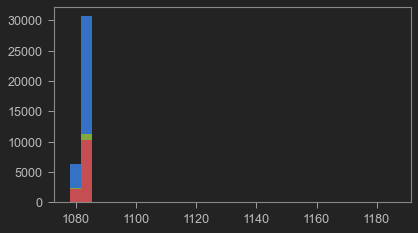

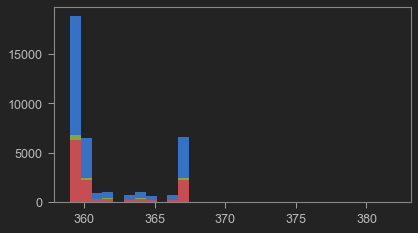

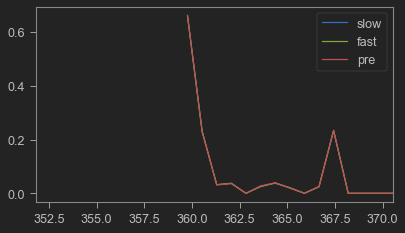

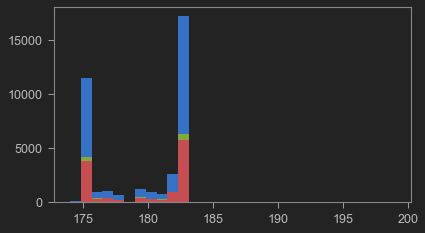

In [98]:
plt.hist(ard_slow['pwm_150:'],bins=30);
plt.hist(ard_fast['pwm_150:'],bins=30);
plt.hist(ard_pre['pwm_150:'],bins=30);

plt.figure()
plt.hist(ard_slow['pwm_100:'],bins=30);
plt.hist(ard_fast['pwm_100:'],bins=30);
plt.hist(ard_pre['pwm_100:'],bins=30);

plt.figure()
smart_hist(ard_slow['pwm_100:'],bins=30,label="slow",norm=True);
smart_hist(ard_fast['pwm_100:'],bins=30,label="fast",norm=True);
smart_hist(ard_pre['pwm_100:'],bins=30,label="pre",norm=True);

plt.figure()
plt.hist(ard_slow['pwm_50:'],bins=30);
plt.hist(ard_fast['pwm_50:'],bins=30);
plt.hist(ard_pre['pwm_50:'],bins=30);

### Ethernet Switch

In [109]:
def find_and_load_data(path,keyword):

    data_file_list = os.listdir(path)

    the_files = []
    for filename in data_file_list:
        if keyword in filename: the_files+=[filename]

    the_data = []
    for filename in the_files:
        df = pd.read_csv(path+filename)
        the_data+= [df]

    result = pd.concat(the_data)
    result.sort_values(by=['time'], inplace=True)

    return result

In [112]:
path = base_path+"ether_switch/data/data/pre_test/2022-06-10_20-09-43/"
eth_pre = find_and_load_data(path,"net")

path = base_path+"ether_switch/data/data/slow_dose/2022-06-12_21-02-03/"
eth_slow = find_and_load_data(path,"net")

path = base_path+"ether_switch/data/data/fast_dose/power_2022-06-15_16-49-09/"
eth_fast = find_and_load_data(path,"net")

In [342]:
eth_fast

,net_info,num_detected_adapters,time
0,"{'lo': snetio(bytes_sent=24269, bytes_recv=242...",3,1.655326e+09
1,"{'lo': snetio(bytes_sent=24269, bytes_recv=242...",3,1.655326e+09
2,"{'lo': snetio(bytes_sent=24269, bytes_recv=242...",3,1.655326e+09
3,"{'lo': snetio(bytes_sent=24269, bytes_recv=242...",3,1.655326e+09
4,"{'lo': snetio(bytes_sent=24269, bytes_recv=242...",3,1.655326e+09
...,...,...,...
45,"{'lo': snetio(bytes_sent=24985, bytes_recv=249...",3,1.655326e+09
46,"{'lo': snetio(bytes_sent=24985, bytes_recv=249...",3,1.655326e+09
47,"{'lo': snetio(bytes_sent=24985, bytes_recv=249...",3,1.655326e+09
48,"{'lo': snetio(bytes_sent=24985, bytes_recv=249...",3,1.655326e+09


#### Example
For this lets look at the only failure we experienced

In [162]:
# grab a random frame from when it was working fine
pre = eth_fast.iloc[1]

# grab last frame in fast dose test assuming it experienced failure
failure = eth_fast.iloc[-1]

# grab the note at the time to make sure its correct
get_note(failure['time'],3)['Notes'][210]

'Done 1650 rad dose\r\nLost ping at near end of dose (180000 MC => 1546 rad\r\nSwitching to direct STU gave ping (after STU only power cycle)\r\nSwitching back to beam config did not bring back\r\nPower cycling switch - back\r\nActually saw a failure on the switch!'

In [163]:
# get the differences between them
set(pre['net_info'].split(" ")) - set(failure['net_info'].split(" "))

{'bytes_recv=24269,',
 'bytes_recv=580015,',
 'packets_recv=283,',
 'packets_recv=6663,',
 'packets_sent=283,',
 'packets_sent=9813,',
 'snetio(bytes_sent=24269,',
 'snetio(bytes_sent=9319798,'}

###  PSRB

In [169]:
path = base_path+"psrb/data/"
psrb_pre = pd.read_csv(path+"triumf_pre_test.csv",comment="#")
psrb_slow = pd.read_csv(path+"triumf_slow_dose.csv",comment="#")

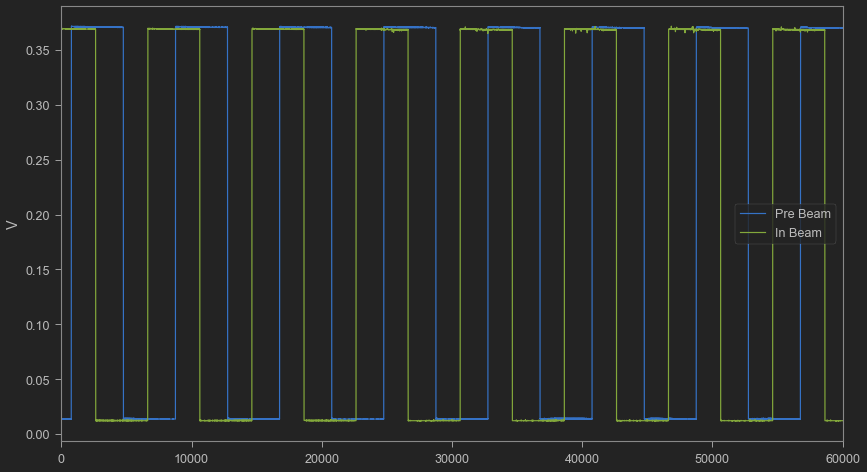

In [177]:
plt.figure(figsize=(14,8))
plt.plot(psrb_pre["Channel 1 (V)"],label="Pre Beam")
plt.plot(psrb_slow["Channel 1 (V)"],label="In Beam")
plt.xlim([0,60000])

plt.ylabel("V")
plt.legend()

### PV Cell

In [178]:
path = base_path+"PV_cell/data/"
pv_pre = pd.read_csv(path+"setup_in_beam.csv",comment="#")
pv_fry = pd.read_csv(path+"fry_test_04.csv",comment="#")

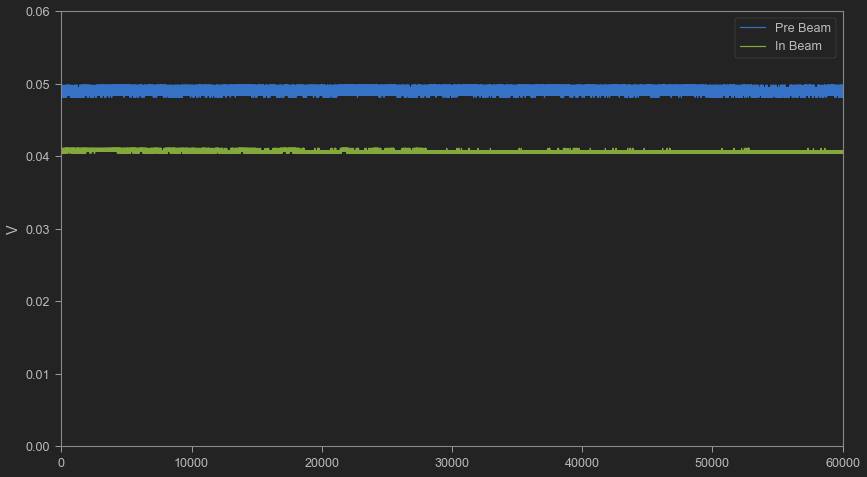

In [185]:
plt.figure(figsize=(14,8))
plt.plot(pv_pre["Channel 2 (V)"],label="Pre Beam")
plt.plot(pv_fry["Channel 2 (V)"],label="In Beam")
plt.xlim([0,60000])
plt.ylim([0,0.06])
plt.ylabel("V")
plt.legend()

### Raspberry PI

In [225]:
def find_and_load_data(path,keyword):
    """Find all the data of a given falvour in a directory and merge them together into a single pandas data frame"""
    data_file_list = os.listdir(path)

    the_files = []
    for filename in data_file_list:
        if keyword in filename: the_files+=[filename]

    the_data = []
    for filename in the_files:
        print(path+filename)
        try:
            df = pd.read_csv(path+filename,comment="#")
            the_data.append(df)
        except pd.errors.EmptyDataError:
            print(" is empty")
    
    result = None
    if len(the_data) > 0:
        result = pd.concat(the_data)
        result.sort_values(by=['time'], inplace=True)

    return result  

class RPI:
    def __init__(self, path=None):
        
        if path is not None:
            rams = []
            nets = []
            cpus = []
            disks = []

            # go through all the directories in the path to create one giant data file
            for directory in os.listdir(path):
                if "2022" in directory:

                    ram = find_and_load_data(path+directory+"/","ram")
                    if ram is not None:
                        rams.append(ram)

                    net = find_and_load_data(path+directory+"/","net")
                    if net is not None:
                        nets.append(net)

                    cpu = find_and_load_data(path+directory+"/","cpu")
                    if cpu is not None:
                        cpus.append(cpu)

                    disk = find_and_load_data(path+directory+"/","disk")
                    if disk is not None:
                        disks.append(find_and_load_data(path+directory+"/","disk"))

            self.ram = pd.concat(rams)
            self.ram.sort_values(by=['time'], inplace=True)

            if len(cpus) > 1:
                self.cpu = pd.concat(cpus)
                self.cpu.sort_values(by=['time'], inplace=True)

            self.disk = pd.concat(disks)
            self.disk.sort_values(by=['time'], inplace=True)

            self.net = pd.concat(nets)
            self.net.sort_values(by=['time'], inplace=True)

#### Example

In [226]:
path = base_path+"SMRT/remotedata/rpi/data/"
rpi = RPI(path)

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-48-53ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-46ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-08ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-14ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-24ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-48-59disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-50disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-48-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-48-27/2022-06-12_18-49-15disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-13ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-02-47ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-02ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-09-14ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-07-21ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-05-16ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-07-11ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-12-20ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-39ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-07-36ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-18net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-08net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-08-15net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-08-20net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-05-32net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-08-45net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-04-46net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-03-35net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-12-24net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-07net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-49net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-10-42net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-08-55net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-08-50net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-33net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-06disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-05-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-02-43disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-10-56disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-09-24disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-09-59disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-05-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-12-07disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-36disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-02-22disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-06-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-03-23disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-03-18disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-09-03disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-07-32disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-07-17disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-09-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-07-27disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-03-28disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-11-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-04-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-12-02disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-06-12_19-10-20disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_19-02-15/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-49-07/2022-06-13_19-49-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-49-07/2022-06-13_19-50-05disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-49-07/2022-06-13_19-50-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-49-07/2022-06-13_19-49-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-49-07/2022-06-13_19-50-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-49-07/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-41-02net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-42-42net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-42-17net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-42-57net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-42-32net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-41-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-41-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-41-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-42-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-06-12_18-42-01disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-40-48/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-47ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-42ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-45-07ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-48-25ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-48-00ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-48-30net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-43-26net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-46-59net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-46-23net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-47net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-46-43net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-11net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-47-54net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-16net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-46-54net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-20disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-47-56disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-43-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-47-31disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-45-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-45-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-46-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-45-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-47-36disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-06-13_19-44-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-13_19-42-57/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-52ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-41ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-43-43ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-10ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-56disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-43-40disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-43-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43-17/2022-06-12_18-44-11disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-43

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-42-58/2022-06-15_19-44-18net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-42-58/2022-06-15_19-43-47net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-42-58/2022-06-15_19-43-52net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-42-58/2022-06-15_19-43-17net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-42-58/2022-06-15_19-44-03net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-42-58/2022-06-15_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-44-24ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-44-13ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-56-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-30ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-45-17ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-17ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-52-18ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-56-17ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-41ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-30ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-49-05ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-58-07ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-41ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-00-17ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-46-19ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-23ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-46-03ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-03ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-53-51ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-49-46ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-04-06ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-52-29ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-49-41ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-54-23ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-00-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-27net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-04-03net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-55-10net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-53-59net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-55-40net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-36net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-47-23net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-51-12net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-02net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-51net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-56net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-46net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-43-50net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-51-32net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-37net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-17net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-54net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-04-08net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-45-42net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-00-35net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-22net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-31net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-55-05net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-58-28net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-43-25net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-44net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-00-50net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-01-25net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-58-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-45-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-1

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-58-11disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-58-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-03disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-55-09disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-54-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-47-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-53-03disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-52-28disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-46-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-48-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-04-09disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-46-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-01-27disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-43disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-46-15disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-53-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-52-48disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-02disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-18disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-48-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-44-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-44-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-48-36disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-45-20disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-53-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-44-20disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-00-12disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-55-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-47-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-47-56disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-02-23disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-57-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-55-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-22disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-01-17disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-58-06disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-07disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_23-03-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-59-31disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-50-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-43-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-54-24disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-06-10_22-53-59disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-10_22-43-01/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-52-35/2022-06-12_18-52-59ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-52-35/2022-06-12_18-53-15ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-52-35/2022-06-12_18-53-04net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-52-35/2022-06-12_18-52-54net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-52-35/2022-06-12_18-52-48net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-52-35/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-37-33/2022-06-15_19-38-17net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-37-33/2022-06-15_19-38-27net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-37-33/2022-06-15_19-37-40disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-37-33/2022-06-15_19-38-21disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-15_19-37-33/2022-06-15_19-38-26disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/dat

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-56-36/2022-06-12_18-57-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-56-36/2022-06-12_18-57-04disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-56-36/2022-06-12_18-57-09disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-56-36/2022-06-12_18-57-14disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/2022-06-12_18-56-36/2022-06-12_18-56-54disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/S

PermissionError: [Errno 13] Permission denied: '/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/rpi/data/rpi_master_ram.csv'

In [229]:
rpi.ram.to_csv(path+"rpi_master_ram.csv",)
rpi.net.to_csv(path+"rpi_master_net.csv")
rpi.disk.to_csv(path+"rpi_master_disk.csv")

In [375]:
rpi.ram.query("time>")

,ram_pct_used,time,upsets
0,84.9,1.654901e+09,0
1,84.9,1.654901e+09,0
2,84.9,1.654901e+09,0
3,84.9,1.654901e+09,0
4,84.9,1.654901e+09,0
...,...,...,...
23,25.8,1.655322e+09,0
24,25.8,1.655322e+09,0
25,25.8,1.655322e+09,0
26,25.8,1.655322e+09,0


<IPython.core.display.Javascript object>


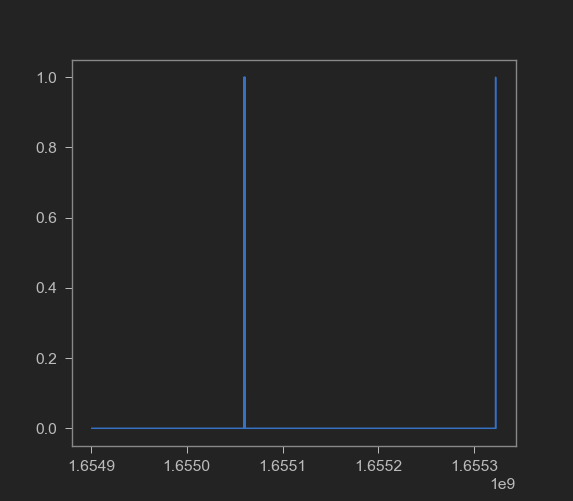

In [374]:
plt.figure()
plt.plot(rpi.ram.time,rpi.ram.upsets)

### ARK

In [248]:
path = base_path+"SMRT/remotedata/ark/data/"
ark = RPI(path)

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-02-29ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-01-32ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-01-48ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-02-34ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-01-58ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-03-15cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-02-04cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-03-05cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-02-19cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-03-20cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-01-40disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-01-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-01-15disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-02-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-06-12_20-02-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_20-00-57/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-57-14/2022-06-12_22-57-41cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-57-14/2022-06-12_22-57-21cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-57-14/2022-06-12_22-57-31cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-57-14/2022-06-12_22-57-32disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-57-14/2022-06-12_22-57-42disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-57-14/2022-06-1

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-49-11net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-49-16net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-50-42net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-50-17net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-49-01net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-50-31disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-49-31disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-49-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-50-16disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-12_22-48-48/2022-06-12_22-49-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-00-58ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-59-02ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-46ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-59-49ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-23ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-09-10ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-44ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-05-58ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-24ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-01-35ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-59-28ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-02-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-09-53ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-46ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-37ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-42ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-36ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-07-40ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-52ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-18ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-32ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-48ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-55-56ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-50-49ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-51ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-08-42net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-21net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-06net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-50-22net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-07-52net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-56net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-00-22net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-26net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-01-33net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-02-49net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-01-13net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-55-10net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-19net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-05-05net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-44net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-04-14net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-02-29net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-53-03net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-11net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-04-30net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-09-48net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-07-47net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-05-30net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-21cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-02-17cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-08-40cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-49cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-16cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-59cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-53-42cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-59-15cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-08cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-55-08cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-45cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-07cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-05-28cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-47cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-59cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-02-12cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-20cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-00-21cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-29cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-51-51cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-50-50cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-50-56cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-08-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-04-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-09-01disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-53-04disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-01-48disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-50-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-07-24disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-59-05disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-07disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-08-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-18disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-55-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-36disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-04disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-15disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-09-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-05-01disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-04-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-08disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-07-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-55disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-00-27disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-05-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-54-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-01-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-55-32disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-48disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-53-55disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-53-14disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-06-23disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-57-03disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-03-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-56-27disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-01-18disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_19-04-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-58-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-52-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-06-10_18-51-12disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-06-10_18-50-14/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-05-27_14-58-41/2022-05-27_14-58-48disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/ark/data/2022-05-27_14-58-41/2022-05-27_14-58-53disk_log.csv


In [257]:
path = base_path+"SMRT/remotedata/ark/data/"
ark.ram.to_csv(path+"ark_master_ram.csv",)
ark.net.to_csv(path+"ark_master_net.csv")
ark.disk.to_csv(path+"ark_master_disk.csv")
ark.cpu.to_csv(path+"ark_master_cpu.csv")

### PCM

In [252]:
path = base_path+"SMRT/remotedata/pcm/data/"
pcm = RPI(path)

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-01-52ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-01-47ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-07ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-27ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-43ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-09disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-24disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-06-12_16-02-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-01-41/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-12net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-33net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-38net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-58-46net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-58-36net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-59-09cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-36cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-30cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-15cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-58-49cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_17-00-31disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-59-55disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-58-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-59-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-06-12_16-58-40disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-58-12/2022-0

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-41-41/2022-06-12_16-42-11ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-41-41/2022-06-12_16-41-56ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-41-41/2022-06-12_16-42-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-41-41/2022-06-12_16-42-21ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-41-41/2022-06-12_16-42-26ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/r

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-46-20ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-15ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-46-25ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-46-14ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-48cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-22cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-27cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-17cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_15-45-07cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-44-51/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-38-07ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-38-27ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-36ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-38-37ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-58cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-38-03cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-48cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-07cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-38cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-36-53disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-49disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-06-12_16-37-28disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-36-46/2022-0

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-11-50/2022-06-15_12-12-33disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-11-50/2022-06-15_12-12-22disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-11-50/2022-06-15_12-12-07disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-11-50/2022-06-15_12-11-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-11-50/2022-06-15_12-12-38disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remote

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-51-43/2022-06-12_15-52-24cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-51-43/2022-06-12_15-52-40cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-51-43/2022-06-12_15-52-45cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-51-43/2022-06-12_15-51-54cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-51-43/2022-06-12_15-52-09cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-27ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-10-02ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-17ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-57ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-07ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-10-39cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-11-04cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-53cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-08-58cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-10-54cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-08-53disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-10-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-10-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-06-12_17-09-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-08-41/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-13-47ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-14-24ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-13-04ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-13-52ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-14-19ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-14-28disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-13-02disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-12-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-14-17disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-06-13_15-13-27disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-12-44/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-42ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-45-00ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-48-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-47ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-27ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-46-24net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-48-46net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-48-00net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-46-39net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-46-29net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-48-14cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-28cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-48-34cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-45-31cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-38cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-46-58disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-49disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-24disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-45-12disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-46-58disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-49disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-47-24disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-06-12_16-45-12disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-44-50/2022-0

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-02net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-08-02net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-12net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-52net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-27net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-51disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-31disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-46disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-11disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-06-53/2022-06-15_12-07-21disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/d

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_16-42-48/2022-06-13_16-43-15disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_16-42-48/2022-06-13_16-43-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_16-42-48/2022-06-13_16-43-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-37ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-26ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-04disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-06-13_15-07-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-06-57/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-22net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-58net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-12net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-10-14net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-28net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-58disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-17disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-12disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-06-13_15-09-43disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-08-08/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-12-30net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-11-50net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-12-20net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-12-00net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-10-52net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-10-51disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-12-01disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-12-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-10-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-06-13_15-11-01disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-13_15-10-23/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-54-54ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-25ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-56-23ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-54-28ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-57ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-06net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-57net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-54-51net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-52net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-26net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-56-05cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-43cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-13cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-54-24cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-56-20cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-55disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-54-55disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-56-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-56-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-53-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-56-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-06-15_11-55-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-53-06/2022-0

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-18-14/2022-06-15_12-18-27disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-18-14/2022-06-15_12-18-22disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-18-14/2022-06-15_12-18-32disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_12-18-14/2022-06-15_12-18-42disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-06-12_16-06-40ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remoted

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-06-12_16-07-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-06-12_16-06-47disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-06-12_16-06-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-06-12_16-06-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-06-12_16-07-23disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-06-35/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-05_16-10-02/2022-06-05_16-10-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-05_16-10-02/2022-06-05_16-10-14disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-05_16-10-02/2022-06-05_16-10-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-05_16-10-02/2022-06-05_16-10-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-05_16-10-02/2022-06-05_16-10-55disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-05_16-10-02/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-59-38/2022-06-12_16-00-49cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-59-38/2022-06-12_16-00-04cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-59-38/2022-06-12_16-00-14cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-59-38/2022-06-12_16-00-34cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-59-38/2022-06-12_16-00-19cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-59-38/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-55-43ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-55-48ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-56-08ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-54-17ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-54-57ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-55-21net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-54-08cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-54-28cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-54-23cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-54-33cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-55-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-56-20disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-56-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-56-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-06-12_16-55-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-53-57/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-29ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-34-35ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-19ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-39ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-44ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-34-51cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-45cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-20cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-34-41cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-25cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-34-37disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-35-02disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-34-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33-08/2022-06-12_16-33-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-33

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_11-59-59ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-01-36net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-00-35net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-00-30net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-00-55net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-01-59cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-03-10cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-24cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-00-28cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-00-53cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-01-50disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-56disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-35disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-05disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-01-40disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-02-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-06-15_12-00-29disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-15_11-59-36/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-35-12ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-34-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-34-26ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-33-55ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-32-58ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-33-04cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-33-39cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-33-50cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-32-43cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-34-25cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-35-01disk_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-34-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-32-49disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-33-05disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32-27/2022-06-12_15-32-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-32

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-51-19/2022-06-12_16-51-29ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-51-19/2022-06-12_16-51-24ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-51-19/2022-06-12_16-51-39ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-51-19/2022-06-12_16-51-34ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_16-51-19/2022-06-12_16-51-27net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigr

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-53ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-06-57ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-52ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-19ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-02ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-52ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-52-03ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-54ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-18ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-46-57ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-10-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-55-39ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-19ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-51-57ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-55-21ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-55-04ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-24ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-58-45ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-45-25ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-48ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-08ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-48-14ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-08-55ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-04-28ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-41ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-52-38ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-39net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-35net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-08-02net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-48-37net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-05-25net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-52-30net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-06-05net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-50-28net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-24net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-05-04net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-57-06net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-11net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-44net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-22net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-46-11net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-56-10net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-42net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-46-21net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-06net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-48-17net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-55-02net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-47net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-45net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-08-17net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-19net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-42net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-44net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-40net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-05-50net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-57net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-56net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-43net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-02-41cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-22cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-04-49cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-56-56cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-34cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-06-46cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-17cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-16cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-31cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-40cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-50-18cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-48cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-43-58cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-56-41cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-58cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-25cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-45-09cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-48-36cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-50-08cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-39cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-08-12cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-05cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-02cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-06-36cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-04-18cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-59-38cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-10-09cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-44cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-47cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-14cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-06-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-59-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-10disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-08disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-50-42disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-58disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-06disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-22disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-05-49disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-05-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-45-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-48-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-06-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-37disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-55-09disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-08-33disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-02-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-57-11disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-40disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-58-06disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-02-25disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-30disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-59disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-09-49disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-05-03disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-54disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-51-02disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-47disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-44disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-52-07disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-47-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-57-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-03disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-02-36disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-04-48disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-51-17disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-02-41disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-03-32disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-08-53disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-54-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-57disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-46-04disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-45-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-18disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-44-19disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-57-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-00-39disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-01-20disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-56-46disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-48-00disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-04-53disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-53-43disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-55-34disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_18-49-16disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-06-10_19-07-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-10_18-43-51/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-48-23/2022-06-12_15-48-54cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-48-23/2022-06-12_15-49-09cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-48-23/2022-06-12_15-49-30cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-48-23/2022-06-12_15-49-04cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-48-23/2022-06-12_15-48-39cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-07-06ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-07-31ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-06-10ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-06-30ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-06-56ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-05-46cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-07-17cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-05-56cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-05-41cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-07-02cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-06-12disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-07-23disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-07-13disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-05-26disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-06-12_17-05-52disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_17-05-14/2022-0

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-55-20ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-55-10ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-56-11ram_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-56-42ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-56-06ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-56-12cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-55-27cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-56-22cpu_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-55-47cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-55-11cpu_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_

 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-54-50/2022-06-12_15-55-38disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-38-37ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-37-40ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-39-30ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-39-12ram_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-40-08net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-40-14net_log.csv
 is empty
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-38-47net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-39-33net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-39-48net_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-39-27disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-37-45disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-39-22disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-38-31disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-40-02disk_log.csv
/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-0

/run/user/1000/gvfs/sftp:host=galadriel.astro.utoronto.ca,user=mshaaban/data2/john/tardigrade/SMRT/remotedata/pcm/data/2022-06-12_15-37-28/2022-06-12_15-40-17disk_log.csv
 is empty


In [256]:
path = base_path+"SMRT/remotedata/pcm/data/"
pcm.ram.to_csv(path+"pcm_master_ram.csv",)
pcm.net.to_csv(path+"pcm_master_net.csv")
pcm.disk.to_csv(path+"pcm_master_disk.csv")
pcm.cpu.to_csv(path+"pcm_master_cpu.csv")

In [363]:
%matplotlib notebook

<IPython.core.display.Javascript object>


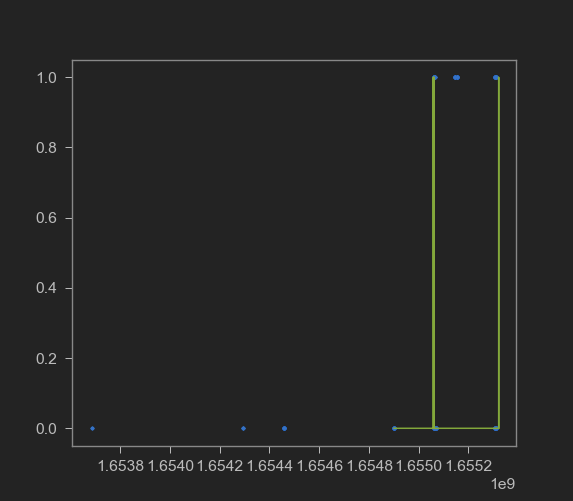

In [370]:
plt.figure()
plt.plot(pcm.ram.time,pcm.ram.upsets,'.')

<IPython.core.display.Javascript object>


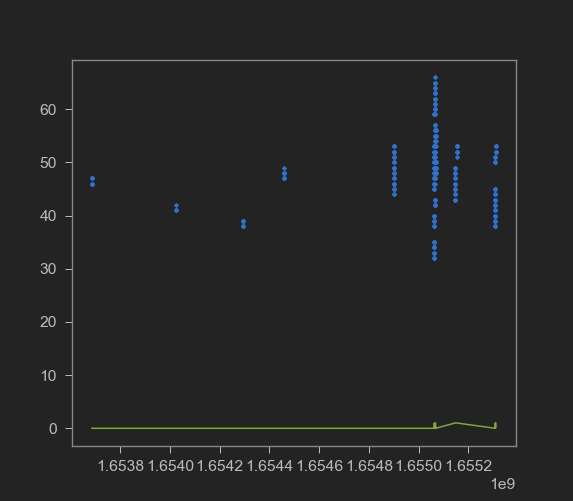

In [365]:
plt.plot(pcm.cpu['time'],pcm.cpu['cpu_temp'],'.')

### Mesa

In [331]:
path = base_path+"SMRT/remotedata/pcm/data/"
test = pd.read_csv(path+ "mesa_ram_fast_aging.csv")

,Time,1655309526,Port,0,1,Port.1,1.1,1.2,Port.2,2,...,Port.20,20,1.21,Port.21,21,1.22,Port.22,22,1.23,Unnamed: 71
0,Time,1655309526,Port,0,0,Port,1,0,Port,2,...,Port,20.0,0.0,Port,21.0,0.0,Port,22.0,0.0,NaN
1,Time,1655309526,Port,0,1,Port,1,1,Port,2,...,Port,20.0,1.0,Port,21.0,1.0,Port,22.0,1.0,NaN
2,Time,1655309526,Port,0,0,Port,1,0,Port,2,...,Port,20.0,0.0,Port,21.0,0.0,Port,22.0,0.0,NaN
3,Time,1655309526,Port,0,1,Port,1,1,Port,2,...,Port,20.0,1.0,Port,21.0,1.0,Port,22.0,1.0,NaN
4,Time,1655309526,Port,0,0,Port,1,0,Port,2,...,Port,20.0,0.0,Port,21.0,0.0,Port,22.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,Time,1655309556,Port,0,0,Port,1,0,Port,2,...,Port,20.0,0.0,Port,21.0,0.0,Port,22.0,0.0,NaN
2847,Time,1655309556,Port,0,1,Port,1,1,Port,2,...,Port,20.0,1.0,Port,21.0,1.0,Port,22.0,1.0,NaN
2848,Time,1655309556,Port,0,0,Port,1,0,Port,2,...,Port,20.0,0.0,Port,21.0,0.0,Port,22.0,0.0,NaN
2849,Time,1655309556,Port,0,1,Port,1,1,Port,2,...,Port,20.0,1.0,Port,21.0,1.0,Port,22.0,1.0,NaN
